Images have very high dimension. The resolution of a 720p video is 1280 * 720. So each frame of that video has the dimension 9e5. Higj dimension data like this is hard to handle. We'd like to use a better representation so we can have a low dimension vector that captures useful information in the image. 

CNN(convolution neural network) is good at doing this. With CNN we can extract low dimension represetation (or feature) from images with rich information so we can classify images or detect objects based extracted features. 

In this project, we use features extracted by CNN to rank images with their similarity.

In [1]:
!pip install opencv-python
import cv2
import numpy as np
from matplotlib import pyplot as plt
import torch
from torchvision.utils import make_grid
from PIL import Image
import glob

     |████████████████████████████████| 43.7MB 22kB/s  eta 0:00:01    |▏                               | 266kB 2.9MB/s eta 0:00:15     |▍                               | 593kB 2.9MB/s eta 0:00:15�█████████████      | 35.6MB 3.5MB/s eta 0:00:03████████████████████████▋     | 36.3MB 3.5MB/s eta 0:00:030:02████▏   | 38.5MB 3.5MB/s eta 0:00:02
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# load data
folder_name = 'celebrity'
image_name = 'celebrity/junkai.jpg'
file_list = []
for f in glob.glob(str(folder_name)+'/*'):
    file_list.append(f)

w = 160
h = 160
image_list = np.zeros((len(file_list), h, w, 3))
for i in range(len(file_list)):
    image_list[i] = np.array(Image.open(file_list[i]).convert('RGB').resize((w,h)))

image_list = torch.from_numpy(image_list).transpose(1,3).transpose(2,3).float()

## CNN as feature extractor

We use a simple CNN network called AlexNet to extract features. The invention of AlexNet in 2012 is the beginning of the deep learning era as it achieves impressing results. More and more researchers turn their attention to deep learning since this success.  

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
from scipy.spatial.distance import cosine
# extract CNN feature for each frame in video
class pretrainedAlexNet(nn.Module):
    def __init__(self):
        super(pretrainedAlexNet, self).__init__()
        self.my_features = models.alexnet(pretrained = True).features
    def forward(self, input):
        feature_map = self.my_features(input)
        return feature_map

net = pretrainedAlexNet()

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /home/nbuser/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [00:27<00:00, 8.83MB/s] 


By passing a 160 * 160 * 3 image(76800 D) to the AlexNet, we get a 4096 D feature vector.  

In [4]:
image = np.array(Image.open(image_name).convert('RGB').resize((w,h)))
print('image: ', image.shape)
# convert to a PyTorch tensor
image = torch.from_numpy(image).unsqueeze(0).transpose(1,3).transpose(2,3).float()
query_feat = net(image)
query_feat = query_feat.flatten()
print('feature: ', query_feat.shape)

image:  (160, 160, 3)
feature:  torch.Size([4096])


## similarity
The measurement of similarity between two feature vectors $u, v$ is the cosine similarity:
$$cos \theta = \frac{u  v}{|u| |v|}$$
This measure the angle between two vectors. If the angle is small, this value is large and it means two vector are similar. 


In [5]:
from scipy.spatial.distance import cosine
cosine_similarity_score_arr = np.zeros((image_list.shape[0]))

# get feature vector of query image
query_feat = net(image)
query_feat_np = query_feat.data.numpy()[0]
# get feature vector for all images
list_feat = net(image_list)

for i in range(list_feat.shape[0]):
    cur_feat_np = list_feat.data.numpy()[i]
    cosine_similarity_score_arr[i] = cosine(query_feat_np.reshape(-1), cur_feat_np.reshape(-1))

sorted_idx = np.argsort(cosine_similarity_score_arr)

# delete the comparison between the query image and itself 
zero_exist = 0
for i in range(len(cosine_similarity_score_arr)):
    if cosine_similarity_score_arr[i] == 0:
        zero_exist = 1

if zero_exist: 
    sorted_idx = np.delete(sorted_idx, 0)

print("cosine_similarity_score_arr: ", cosine_similarity_score_arr)
print('sorted_idx: ', sorted_idx)

cosine_similarity_score_arr:  [0.33803886 0.         0.39889979 0.22456104 0.39544559 0.13554668
 0.32389253 0.11645651]
sorted_idx:  [7 5 3 6 0 4 2]


In [6]:
def show(img):
    npimg = img.numpy()
    plt.figure()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

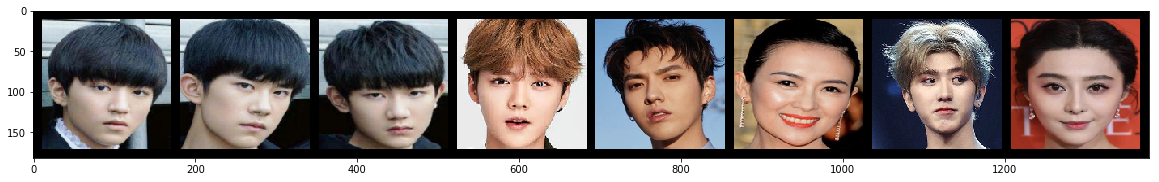

In [8]:
rank_image_arr = torch.zeros((len(sorted_idx)+1, image_list.shape[1], image_list.shape[2], image_list.shape[3]))
rank_image_arr[0] = image
for i in range(len(sorted_idx)):
    idx = sorted_idx[i]
    rank_image_arr[i+1] = image_list[idx]

plt.rcParams["figure.figsize"] = (20,10)
# rank_image_arr_tensor = torch.from_numpy(rank_image_arr).transpose(1,3).transpose(2,3)
show(make_grid(rank_image_arr, nrow=image_list.shape[0]+1, padding=11, normalize=True))

The first image is the query image. Other images are ranked by their similarity to the query image. 